In [ ]:
!pip install Sastrawi
!pip install emoji
!pip install gensim
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 53.0 MB/s eta 0:00:00


In [ ]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt_tab')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.
import re
import string
import emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Memuat Dataset
df = pd.read_csv('youtube-comments-KECURANGAN-PEMILU.csv')
df.head()

,Date,UserName,Comment,Like
0,2025-10-10T16:57:17Z,@yoyokaldifelaniindosat5345,Einstein : 😒 Lavoisier : 😒,0
1,2025-10-10T16:51:49Z,@yoyokaldifelaniindosat5345,Openheimer : 😒,0
2,2025-10-10T15:58:22Z,@yoyokaldifelaniindosat5345,"hrus nya sprti ni jawaban jokowi, gibran & Ter...",0
3,2025-09-16T15:53:59Z,@buyungmsc2368,QODARI JILAT TERUS,0
4,2025-09-09T02:25:38Z,@BambangIrawan-r7t,Saat Qodari menjawab pertanyaan Tejo lalu bung...,0


In [ ]:
# Menampilkan informasi dari dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40457 entries, 0 to 40456
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      40457 non-null  object
 1   UserName  40455 non-null  object
 2   Comment   40427 non-null  object
 3   Like      40457 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [ ]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN) dari app_reviews_df
clean_df = df.dropna()

In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40425 entries, 0 to 40456
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      40425 non-null  object
 1   UserName  40425 non-null  object
 2   Comment   40425 non-null  object
 3   Like      40425 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [ ]:
# Memeriksa dataset apakah ada duplikat
clean_df.duplicated().sum()

np.int64(17)

In [ ]:
# Menghapus baris duplikat dari Dataframe
clean_df = clean_df.drop_duplicates()

# Preprocessing Text

In [ ]:
def cleaningText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Menghapus mention
  text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Menghapus hastag
  text = re.sub(r'RT[\s]+', '', text)  # Menghapus RT
  text = re.sub(r"https\S+", '', text)  # Menghapus link
  text = re.sub(r'[0-9]+', '', text)   # Menghapus angka
  text = re.sub(r'[^\w\s]', '', text)  # Menghapus karakter
  text = text.replace('\n', ' ')  # Mengganti baris baru dengan spasi
  text = text.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca
  text = text.strip(' ')   # Menghapus karakter spasi dari kiri dan kanan teks
  return text

def remove_emoji(text):
    if isinstance(text, str):
        return emoji.replace_emoji(text, replace='')
    else:
        return text

def caseFoldingText(text):     # Mengubah semua karakter dalam teks menjadi hurup kecil
    text = text.lower()
    return text

def tokenizingText(text):      # Memecah atau membagi string teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(["yang", "dan", "di", "ke", "dari", "itu", "ini", "saya", "kamu", "untuk", "pada", "dengan", "ada", "tidak", "ya", "kok", "sih", "atau",'iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []

    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text =  filtered
    return text

def stemmingText(text):
  # Membuat obej stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap data dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah di stemming menjadi satu teks
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentece(list_words):  # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join( word for word in list_words)
    return sentence

In [ ]:
slangwords = {"@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [ ]:
# Membersihkan text dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['Comment'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(caseFoldingText)

# Mneghapus emoji
clean_df['text_removeEmoji'] = clean_df['text_casefoldingText'].apply(remove_emoji)

# Mengganti kata-kata slang dengan kata-kata standar dan meyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_removeEmoji'].apply(fix_slangwords)

# Memecah teks menjadi token(kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop(kata-kata umum) dan menyimpannya di text_stopword
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentece)

In [ ]:
import csv
import requests
from io import StringIO

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter='\t')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
    next(reader) # Skip header row

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter='\t')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
    next(reader) # Skip header row

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [ ]:
# Fungsi untuk menentukan polaritas sentimen dari tweet
def sentiment_analysis_lexicon_indonesia(text):

    # Inisialisasi skor sentimen 0
    score = 0

    # Mengulangi setiap kata dalam teks
    for word in text:
        if (word in lexicon_positive):
          score = score + lexicon_positive[word]  # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:    # Mengualangi setiap kata dalam teks(sekali lagi)
        if (word in lexicon_negative):
          score = score + lexicon_negative[word]  # Jika kata ada dalam kamus negatif, tambahkan skornya ke skor sentimen

    # Inisialisasi variabel polaritas
    polarity = ''

    if (score > 0):
        polarity = 'positive'   # Jika skor sentimen lebih dari 0, maka polaritas adalah positive
    elif (score < 0):
        polarity = 'negative'   # Jika skor sentimen kurang dari 0, maka polaritas adalah negative
    else:
        polarity = 'neutral'    # Jika skor sentimen adalah 0, maka polaritas adalah neutral

    return score, polarity    # Mengembalikan skor sentimen dan polaritas teks

In [ ]:
# Pisahkan skor sentimen dan polaritas
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
negative    19461
positive    11124
neutral      9823
Name: count, dtype: int64


In [ ]:
# Mengecekk missing values
missing_values = clean_df.isnull().sum()
print("Mising values: ", missing_values)

Mising values:  Date                    0
UserName                0
Comment                 0
Like                    0
text_clean              0
text_casefoldingText    0
text_removeEmoji        0
text_slangwords         0
text_tokenizingText     0
text_stopword           0
text_akhir              0
polarity_score          0
polarity                0
dtype: int64


In [ ]:
clean_df.head(20)

,Date,UserName,Comment,Like,text_clean,text_casefoldingText,text_removeEmoji,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,2025-10-10T16:57:17Z,@yoyokaldifelaniindosat5345,Einstein : 😒 Lavoisier : 😒,0,Einstein Lavoisier,einstein lavoisier,einstein lavoisier,einstein lavoisier,"[einstein, lavoisier]","[einstein, lavoisier]",einstein lavoisier,0,neutral
1,2025-10-10T16:51:49Z,@yoyokaldifelaniindosat5345,Openheimer : 😒,0,Openheimer,openheimer,openheimer,openheimer,[openheimer],[openheimer],openheimer,0,neutral
2,2025-10-10T15:58:22Z,@yoyokaldifelaniindosat5345,"hrus nya sprti ni jawaban jokowi, gibran & Ter...",0,hrus nya sprti ni jawaban jokowi gibran Termu...,hrus nya sprti ni jawaban jokowi gibran termu...,hrus nya sprti ni jawaban jokowi gibran termu...,harus nya seperti ini jawaban jokowi gibran te...,"[harus, nya, seperti, ini, jawaban, jokowi, gi...","[jokowi, gibran, termul]",jokowi gibran termul,0,neutral
3,2025-09-16T15:53:59Z,@buyungmsc2368,QODARI JILAT TERUS,0,QODARI JILAT TERUS,qodari jilat terus,qodari jilat terus,qodari jilat terus,"[qodari, jilat, terus]","[qodari, jilat]",qodari jilat,-3,negative
4,2025-09-09T02:25:38Z,@BambangIrawan-r7t,Saat Qodari menjawab pertanyaan Tejo lalu bung...,0,Saat Qodari menjawab pertanyaan Tejo lalu bung...,saat qodari menjawab pertanyaan tejo lalu bung...,saat qodari menjawab pertanyaan tejo lalu bung...,saat qodari menjawab pertanyaan tejo lalu bung...,"[saat, qodari, menjawab, pertanyaan, tejo, lal...","[qodari, tejo, rocky, dlm, hatinya, bicara, be...",qodari tejo rocky dlm hatinya bicara berak qod,-4,negative
5,2025-08-20T15:55:11Z,@zerohero-e7e,Njirr kodari... Amit2😂,0,Njirr kodari Amit,njirr kodari amit,njirr kodari amit,njirr kodari amit,"[njirr, kodari, amit]","[njirr, kodari, amit]",njirr kodari amit,-4,negative
6,2025-08-17T01:01:19Z,@Buhari-cj4go,Kasihan melihat orang orang ini yg gagal menja...,0,Kasihan melihat orang orang ini yg gagal menja...,kasihan melihat orang orang ini yg gagal menja...,kasihan melihat orang orang ini yg gagal menja...,kasihan melihat orang orang ini yang gagal men...,"[kasihan, melihat, orang, orang, ini, yang, ga...","[kasihan, orang, orang, gagal, manusiaeee, bin...",kasihan orang orang gagal manusiaeee binatang,-3,negative
7,2025-07-15T18:50:50Z,@dickyyoga4756,Sayang sekali td tdk diterusin tentang ijazah ...,0,Sayang sekali td tdk diterusin tentang ijazah ...,sayang sekali td tdk diterusin tentang ijazah ...,sayang sekali td tdk diterusin tentang ijazah ...,sayang sekali tadi tidak diterusin tentang ija...,"[sayang, sekali, tadi, tidak, diterusin, tenta...","[sayang, diterusin, ijazah, iqbal, ketewa, ber...",sayang diterusin ijazah iqbal ketewa berhenti ...,3,positive
8,2025-07-15T09:25:22Z,@sandraoreski5542,"Go to theatre acctors, wrong speach is l...",0,Go to theatre acctors wrong speach is lu...,go to theatre acctors wrong speach is lu...,go to theatre acctors wrong speach is lu...,go to theatre acctors wrong speach is luke kin...,"[go, to, theatre, acctors, wrong, speach, is, ...","[go, theatre, acctors, wrong, speach, luke, ki...",go theatre acctors wrong speach luke kindergar...,0,neutral
9,2025-07-14T18:01:00Z,@Dediibrahim-w1q,Gak malu si haikal ini.....,0,Gak malu si haikal ini,gak malu si haikal ini,gak malu si haikal ini,gak malu si haikal ini,"[gak, malu, si, haikal, ini]","[malu, si, haikal]",malu si haikal,-2,negative


In [ ]:
# Menyimpan Dataset yang sudah bersih
clean_df.to_csv("Dataset_Cleaning_Sentimen.csv", index=False)

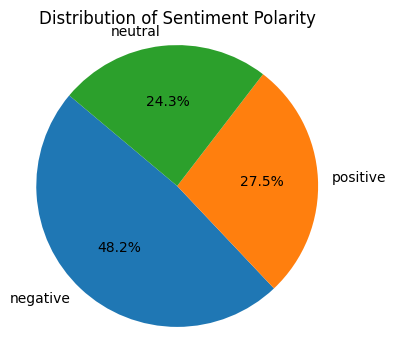

In [ ]:
# Membuat visualisasi dari polarity dengan pie Chart
polarity_counts = clean_df['polarity'].value_counts()


plt.figure(figsize=(4, 4))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiment Polarity')
plt.axis('equal')
plt.show()

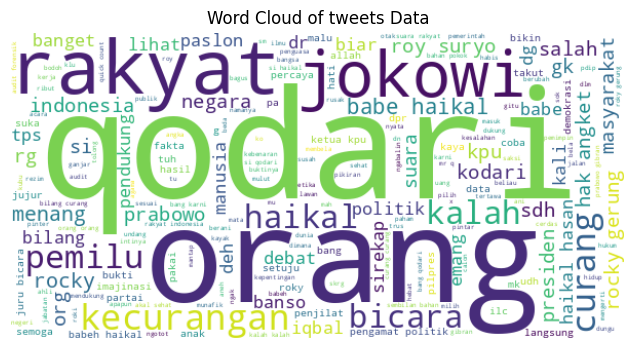

In [ ]:
# Visualisasi deng WordCloud
from wordcloud import WordCloud

# Join all the cleaned text into a single string
all_text = ' '.join(clean_df['text_akhir'])

# Generate the wordcloud
wordcloud = WordCloud(width=600, height=300, background_color='white').generate(all_text)

# Display the wordcloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of tweets Data')
plt.axis('off')
plt.show()

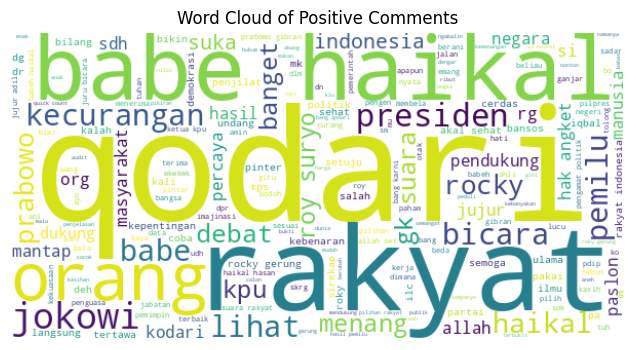

In [ ]:
# Filter comments by polarity
positive_comments = clean_df[clean_df['polarity'] == 'positive']['text_akhir']


# Generate Word Cloud for Positive Comments
if not positive_comments.empty:
    positive_text = ' '.join(positive_comments)
    positive_wordcloud = WordCloud(width=600, height=300, background_color='white').generate(positive_text)

    plt.figure(figsize=(8, 4))
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title('Word Cloud of Positive Comments')
    plt.axis('off')
    plt.show()
else:
    print("No positive comments to generate word cloud.")

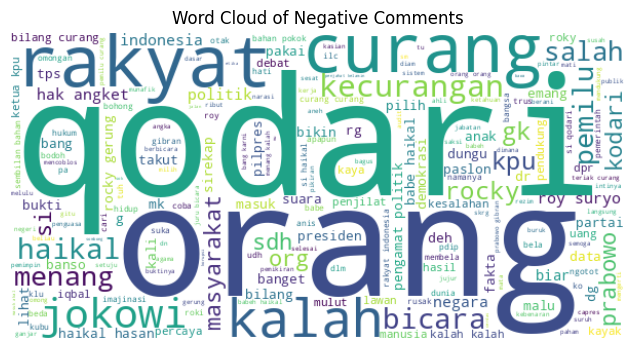

In [ ]:
# Filter comments by polarity
negative_comments = clean_df[clean_df['polarity'] == 'negative']['text_akhir']

# Generate Word Cloud for Negative Comments
if not negative_comments.empty:
    negative_text = ' '.join(negative_comments)
    negative_wordcloud = WordCloud(width=600, height=300, background_color='white').generate(negative_text)

    plt.figure(figsize=(8, 4))
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title('Word Cloud of Negative Comments')
    plt.axis('off')
    plt.show()
else:
    print("No negative comments to generate word cloud.")

# Data Splitting dan Ekstraksi Fitur dengan TF-IDF (80:20)

In [ ]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = clean_df['text_akhir']
y = clean_df['polarity']

# Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=20000, min_df=20, max_df=0.9 )
X_tfidf = tfidf.fit_transform(X)

# Menerapkan SMOTE *after* TF-IDF
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y_encoded)

# Spilitting Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
! pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.2 MB/s eta 0:00:00


# Modeling dengan Algoritma SVC + TF-IDF + OPTUNA

In [ ]:

def objective(trial):
    # Mendefiniskan ruang pencarian untuk hyperparameter
    params = {
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
        'loss': trial.suggest_categorical('loss', ['hinge', 'squared_hinge']),
        # Toleransi untuk kriteria berhenti
        'tol': trial.suggest_float('tol', 1e-5, 1e-1, log=True),
        # Diperlukan untuk reproduktifitas
        'random_state': 42,
        # Meningkatkan iterasi maksimum untuk memastikan konvergensi
        'max_iter': 5000
    }
    # Membuat model dengan hyperparameter yang disarankan oleh "trial"
    model_svc_tfidf = LinearSVC(**params)

    # Buat Cross Validation pada data training
    scores = cross_val_score(model_svc_tfidf, X_train, y_train, cv=3, scoring='accuracy') # Reduced cross-validation folds

    # Ambil rata-rata akurasi dari semua fold
    accuracy = np.mean(scores)

    # Return nilai akurasi sebagai tujuan optimasi
    return accuracy

# Menjalankan Optimasi
study = optuna.create_study(direction='maximize', study_name='LinearSVC')
study.optimize(objective, n_trials=200,timeout=300*12) # berhenti jika 1 jam belum selesai

# Hasil Optimasi
print('Number of finished trials:', len(study.trials))
# Menampilkan trial terbaik
best_trial = study.best_trial
print(f"\nSkor Akurasi (CV) Terbaik: {best_trial.value:.4f}")
print("Hyperparameter Terbaik:")
for key, value in best_trial.params.items():
    print(f"  - {key}: {value}")

# Melatih model final dengan hyperparameter terbaik pada SELURUH data latih
final_model_svc_tfidf = LinearSVC(**best_trial.params, random_state=42, max_iter=5000)
final_model_svc_tfidf.fit(X_train, y_train)

# Evaluasi akhir pada data uji (test set)
final_accuracy = final_model_svc_tfidf.score(X_test, y_test)
print(f"\nAkurasi model final di data test: {final_accuracy:.4f}")

[I 2025-10-21 04:29:16,791] A new study created in memory with name: LinearSVC
[I 2025-10-21 04:29:18,763] Trial 0 finished with value: 0.7403972865127514 and parameters: {'C': 0.001305024016261104, 'loss': 'hinge', 'tol': 0.0002274920463601101}. Best is trial 0 with value: 0.7403972865127514.
[I 2025-10-21 04:29:20,573] Trial 1 finished with value: 0.7375925195998381 and parameters: {'C': 0.0010216787761218732, 'loss': 'hinge', 'tol': 3.0837535352782724e-05}. Best is trial 0 with value: 0.7403972865127514.
[I 2025-10-21 04:29:21,493] Trial 2 finished with value: 0.7264161510592229 and parameters: {'C': 0.005267952165780961, 'loss': 'squared_hinge', 'tol': 0.03590833301961197}. Best is trial 0 with value: 0.7403972865127514.
[I 2025-10-21 04:29:22,384] Trial 3 finished with value: 0.6538130982785227 and parameters: {'C': 0.0001461569530697371, 'loss': 'squared_hinge', 'tol': 0.0049259948476285155}. Best is trial 0 with value: 0.7403972865127514.
[I 2025-10-21 04:29:23,304] Trial 4 fini

Number of finished trials: 167

Skor Akurasi (CV) Terbaik: 0.8742
Hyperparameter Terbaik:
  - C: 65.12092439213272
  - loss: hinge
  - tol: 0.000510836864031013

Akurasi model final di data test: 0.8873


In [ ]:
# save model linear SVC + TFIDF dengan pickle
import pickle
filename = 'model_linearSVC_tfidf.pkl'
pickle.dump(final_model_svc_tfidf, open(filename, 'wb'))

In [ ]:
# save vectorizer TFIDF
filename = 'vectorizer_tfidf.pkl'
pickle.dump(tfidf, open(filename, 'wb'))

# Ekstraksi fitur dengan BoW  (70:30)

In [ ]:
# Pisahkan Data Train dan Test
X = clean_df['text_akhir']
y = clean_df['polarity']

le = LabelEncoder()
y_le = le.fit_transform(y)

# Ekstraksi fitur dengan Bow
bow = CountVectorizer()
X_bow= bow.fit_transform(X)

# Menerapkan SMOTE
smote_bow = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote_bow.fit_resample(X_bow, y_le)

# Splitting
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_train_sm, y_train_sm, test_size=0.3, random_state=42)

# Modeling dengan Algoritma SVC + BoW + OPTUNA

In [ ]:
def objective(trial):
    # Mendefiniskan ruang pencarian untuk hyperparameter
    params = {
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
        'loss': trial.suggest_categorical('loss', ['hinge', 'squared_hinge']),
        # Toleransi untuk kriteria berhenti
        'tol': trial.suggest_float('tol', 1e-5, 1e-1, log=True),
        # Diperlukan untuk reproduktifitas
        'random_state': 42,
        # Meningkatkan iterasi maksimum untuk memastikan konvergensi
        'max_iter': 5000
    }
    # Membuat model dengan hyperparameter yang disarankan oleh "trial"
    model = LinearSVC(**params)

    # Buat Cross Validation pada data training
    scores = cross_val_score(model, X_train_bow, y_train_bow, cv=5, scoring='accuracy') # Reduced cross-validation folds

    # Ambil rata-rata akurasi dari semua fold
    accuracy = np.mean(scores)

    # Return nilai akurasi sebagai tujuan optimasi
    return accuracy

# Menjalankan Optimasi
study = optuna.create_study(direction='maximize', study_name='LinearSVC')
study.optimize(objective, n_trials=50,timeout=300*12)

# Hasil Optimasi
print('Number of finished trials:', len(study.trials))
# Menampilkan trial terbaik
best_trial = study.best_trial
print(f"\nSkor Akurasi (CV) Terbaik: {best_trial.value:.4f}")
print("Hyperparameter Terbaik:")
for key, value in best_trial.params.items():
    print(f"  - {key}: {value}")

# Melatih model final dengan hyperparameter terbaik pada SELURUH data latih
final_model = LinearSVC(**best_trial.params, random_state=42, max_iter=5000)
final_model.fit(X_train_bow, y_train_bow)

# Evaluasi akhir pada data uji (test set)
final_accuracy = final_model.score(X_test_bow, y_test_bow)
print(f"\nAkurasi model final di data test: {final_accuracy:.4f}")

[I 2025-10-21 06:21:08,845] A new study created in memory with name: LinearSVC
[I 2025-10-21 06:21:11,608] Trial 0 finished with value: 0.6692031694949063 and parameters: {'C': 0.0004417617017744357, 'loss': 'squared_hinge', 'tol': 2.3770783727321764e-05}. Best is trial 0 with value: 0.6692031694949063.
[I 2025-10-21 06:21:16,611] Trial 1 finished with value: 0.8249486431643624 and parameters: {'C': 0.062176763185072696, 'loss': 'squared_hinge', 'tol': 0.010480106250444973}. Best is trial 1 with value: 0.8249486431643624.
[I 2025-10-21 06:21:20,775] Trial 2 finished with value: 0.6658998484898879 and parameters: {'C': 0.00041174020977948074, 'loss': 'squared_hinge', 'tol': 1.0411931965218883e-05}. Best is trial 1 with value: 0.8249486431643624.
[I 2025-10-21 06:23:49,630] Trial 3 finished with value: 0.8381375192343956 and parameters: {'C': 36.56055798167361, 'loss': 'hinge', 'tol': 0.0002714576633148851}. Best is trial 3 with value: 0.8381375192343956.
[I 2025-10-21 06:23:50,307] Tria

Number of finished trials: 50

Skor Akurasi (CV) Terbaik: 0.8547
Hyperparameter Terbaik:
  - C: 2.1750451486886413
  - loss: hinge
  - tol: 0.004921806008691955

Akurasi model final di data test: 0.8621


# Modeling dengan Algoritma Logistic Regression + TF-IDF + OPTUNA

In [ ]:
# Objective Function untuk Logistic Regression
def objective(trial):
    # Definisikan ruang pencarian untuk Logistic Regression
    params = {
        'C': trial.suggest_float('C', 1e-2, 1e2, log=True),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'random_state': 42,
        'max_iter': 200
    }

    # Penyesuaian: 'liblinear' tidak mendukung penalty 'none' di beberapa versi
    if params['solver'] == 'liblinear' and params['penalty'] == 'l1':
        pass # liblinear mendukung l1
    elif params['solver'] == 'liblinear' and params['penalty'] == 'l2':
        pass # liblinear mendukung l2
    elif params['solver'] == 'saga':
        pass # saga mendukung l1 dan l2
    else: # Jika kombinasi tidak valid, Optuna akan coba lagi
        pass

    # Buat model
    model_lr = LogisticRegression(**params)

    # Lakukan Cross-Validation pada data training
    scores = cross_val_score(model_lr, X_train, y_train, cv=3, scoring='accuracy')
    accuracy = np.mean(scores)

    return accuracy

# Menjalankan Studi Optimisasi
study = optuna.create_study(direction='maximize', study_name='logistic_regression')
study.optimize(objective, n_trials=50,timeout=300*12)

# Analisis dan Evaluasi Final
best_trial = study.best_trial
print(f"\nSkor Akurasi (CV) Terbaik: {best_trial.value:.4f}")
print("Hyperparameter Terbaik:")
for key, value in best_trial.params.items():
    print(f"  - {key}: {value}")


# Melatih model final dengan parameter terbaik
print("Melatih model final pada data training...")
final_model_lr = LogisticRegression(**best_trial.params, random_state=42, max_iter=200)
final_model_lr.fit(X_train, y_train)

# Evaluasi akhir pada data uji (X_test)
final_accuracy_lr = final_model_lr.score(X_test, y_test)
print(f"\nAkurasi model final di data test: {final_accuracy_lr:.4f}")

[I 2025-10-24 05:17:05,176] A new study created in memory with name: logistic_regression
[I 2025-10-24 05:17:08,960] Trial 0 finished with value: 0.751102636329592 and parameters: {'C': 0.13844834915396925, 'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.751102636329592.
[I 2025-10-24 05:17:29,108] Trial 1 finished with value: 0.8605532904819535 and parameters: {'C': 59.71121900978756, 'solver': 'saga', 'penalty': 'l2', 'class_weight': None}. Best is trial 1 with value: 0.8605532904819535.
[I 2025-10-24 05:17:29,721] Trial 2 finished with value: 0.7287287931140823 and parameters: {'C': 0.04557865875928704, 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8605532904819535.
[I 2025-10-24 05:23:41,281] Trial 3 finished with value: 0.8608316351057415 and parameters: {'C': 55.269829455082295, 'solver': 'saga', 'penalty': 'l1', 'class_weight': None}. Best is trial 3 with value: 0.8608316351057415.


Skor Akurasi (CV) Terbaik: 0.8659
Hyperparameter Terbaik:
  - C: 3.8567449958981466
  - solver: saga
  - penalty: l1
  - class_weight: balanced
Melatih model final pada data training...

Akurasi model final di data test: 0.8751


# Model Deep Learning

In [ ]:
# Import library
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Siapkan parameter
vocab_size = 10000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
num_epochs = 20

# Membuat Objek Encoder
encoder = OneHotEncoder()
# Melakukan encoding pada variabel target Y
encoded_data = encoder.fit_transform(clean_df[['polarity']])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out())
# gabungkan ke data frame
df_fix = pd.concat([clean_df.reset_index(drop=True), encoded_df], axis=1)

In [ ]:

# Splitting data
x_tf = df_fix['text_akhir'].values
y_tf = df_fix[['polarity_negative', 'polarity_neutral', 'polarity_positive']].values


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_tf)

#membagi data train sebesar 70% dan test sebesar 30%
X_train_tf, X_test_tf, Y_train_tf, Y_test_tf = train_test_split(x_tf , y_tf, test_size=0.2, random_state=42) # Added random_state for reproducibility

# Ensure target variables are float32 after splitting
#Y_train_tf = Y_train_tf.astype(np.float32)
#Y_test_tf = Y_test_tf.astype(np.float32)
# Pastikan data bersih
#X_train_tf = pd.Series(X_train_tf).fillna('').astype(str).values
#X_test_tf = pd.Series(X_test_tf).fillna('').astype(str).values
sekuens_train = tokenizer.texts_to_sequences(X_train_tf)
sekuens_val = tokenizer.texts_to_sequences(X_test_tf)
X_train = pad_sequences(sekuens_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test = pad_sequences(sekuens_val, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [ ]:
# Menerapkan SMOTE
smote = SMOTE(random_state=42)
X_train_sm, Y_train_sm = smote.fit_resample(X_train, Y_train_tf)

In [ ]:
# Data sebelum smote
print("Jumlah data sebelum SMOTE:", Y_train_tf.shape[0])

# Data setelah smote
print("Jumlah data setelah SMOTE:", Y_train_sm.shape[0])

Jumlah data sebelum SMOTE: 32326
Jumlah data setelah SMOTE: 46557


In [ ]:
#model untuk train
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,    output_dim=embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.build(input_shape=( None,None))
model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=7,
    restore_best_weights=True,
    verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=0.00001)

print("\nMemulai proses training model")
history = model.fit(X_train_sm, Y_train_sm,
                    epochs=num_epochs,
                    validation_data=(X_test, Y_test_tf),
                    callbacks=[early_stopping, reduce_lr],
                    batch_size=64,
                    verbose=2
                    )

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, None, 128)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,576,451 (6.01 MB)

 Trainable params: 1,576,451 (6.01 MB)

 Non-trainable params: 0 (0.00 B)


Memulai proses training model
Epoch 1/20
728/728 - 325s - 446ms/step - accuracy: 0.6601 - loss: 0.7685 - val_accuracy: 0.8422 - val_loss: 0.4976 - learning_rate: 1.0000e-03
Epoch 2/20
728/728 - 315s - 433ms/step - accuracy: 0.7813 - loss: 0.5449 - val_accuracy: 0.8589 - val_loss: 0.4504 - learning_rate: 1.0000e-03
Epoch 3/20
728/728 - 315s - 432ms/step - accuracy: 0.8293 - loss: 0.4335 - val_accuracy: 0.8503 - val_loss: 0.4549 - learning_rate: 1.0000e-03
Epoch 4/20

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
728/728 - 307s - 422ms/step - accuracy: 0.8613 - loss: 0.3515 - val_accuracy: 0.8414 - val_loss: 0.4786 - learning_rate: 1.0000e-03
Epoch 5/20
728/728 - 307s - 422ms/step - accuracy: 0.9117 - loss: 0.2351 - val_accuracy: 0.8215 - val_loss: 0.6015 - learning_rate: 2.0000e-04
Epoch 6/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
728/728 - 329s - 452ms/step - accuracy: 0.9266 - loss: 0.1975 - val_accuracy: 0.8163 - 

In [ ]:
# Evaluasi Model
loss, accuracy = model.evaluate(X_test, Y_test_tf, verbose=0)
print(f"\nAkurasi Model di Data Uji: {accuracy*100:.2f}%")


Akurasi Model di Data Uji: 85.89%


## Inference Pengujian Hasil

In [ ]:
# Buat pengujian model (Logidtic Regresion)
test = "si rocky gekar taoi ngaku² profesor"  # Sentimen Neutral

X_new = tfidf.transform([test])
prediction = final_model_lr.predict(X_new)
print("Prediksi : ",prediction)

# Konversi hasil numerik ke teks
predicted_label = le.inverse_transform(prediction)
print("Hasil Prediksi : ",predicted_label)

Prediksi :  [1]
Hasil Prediksi :  ['neutral']


In [ ]:
# Buat pengujian model(LinearSVC)
test = "jokowi sengaja adu domba argumen"  # Sentimen Negative

X_new = tfidf.transform([test])
prediction = final_model_svc_tfidf.predict(X_new)
print("Prediksi : ",prediction)

# Konversi hasil numerik ke teks
predicted_label = le.inverse_transform(prediction)
print("Hasil Prediksi : ",predicted_label)

Prediksi :  [0]
Hasil Prediksi :  ['negative']
